Questions 3 and 4: 

Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts

In [1]:
#import packages
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pyxlsb


In [7]:
# Load data
emissions = pd.read_excel('emissions_by_unit_and_fuel_type_c_d_aa.xlsb', skiprows = 6)
emissions.head()

,Facility Id,FRS Id,Facility Name,City,State,Primary NAICS Code,Reporting Year,Industry Type (subparts),Industry Type (sectors),Unit Name,Unit Type,Unit Reporting Method,Unit Maximum Rated Heat Input Capacity (mmBTU/hr),Unit CO2 emissions (non-biogenic),Unit Methane (CH4) emissions,Unit Nitrous Oxide (N2O) emissions,Unit Biogenic CO2 emissions (metric tons)
0,1001155,1.100004e+11,1500 South Tibbs LLC d/b/a Aurorium Indianapol...,Indianapolis,IN,325199.0,2023,C,Chemicals,GP-1,NaN,Tier1/2/3,91.8,64740.5,30.50,36.356,0.0
1,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2018,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.0,3304.7,1.50,1.788,0.0
2,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2018,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.01,OCS (Other combustion source),Tier1/2/3,30.0,0.2,0.00,0.000,0.0
3,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2018,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.02,OCS (Other combustion source),Tier1/2/3,30.0,175.0,0.00,0.000,0.0
4,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130.0,2017,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.0,9106.1,4.25,5.066,0.0


In [8]:
# Load area data
area = pd.read_csv('state_areas.csv', skiprows = 2)
area.head()

,EPA Region,State/Territory,Size Score,Sq. Mi.,Sq. Km.,Sq. Mi..1,Sq. Km..1,Sq. Mi..2,Sq. Km..2,Sq. Mi..3,Sq. Km..3,Sq. Mi..4,Sq. Km..4,Sq. Mi..5,Sq. Km..5,Sq. Mi..6,Sq. Km..6,Unnamed: 17,Unnamed: 18
0,4.0,Alabama,2,"52,420","135,767","50,645","131,171","1,775","4,597","1,058","2,740",517,"1,340",—,—,199,516,32.739632,-86.843459
1,10.0,Alaska,3,"665,384","1,723,337","570,641","1,477,953","94,743","245,383","19,304","49,997","26,119","67,647",—,—,"49,320","127,739",63.346191,-152.837068
2,9.0,American Samoa,1,581,"1,505",76,198,505,"1,307",8,21,—,—,—,—,497,"1,286",-14.263817,-170.662090
3,9.0,Arizona,3,"113,990","295,234","113,594","294,207",396,"1,026",396,"1,026",—,—,—,—,—,—,34.209964,-111.602401
4,6.0,Arkansas,2,"53,179","137,732","52,035","134,771","1,143","2,961","1,143","2,961",—,—,—,—,—,—,34.895526,-92.444626


In [5]:
# Get column names
print(emissions.columns)
print(area.columns)

Index(['Facility Id', 'FRS Id', 'Facility Name', 'City', 'State',
       'Primary NAICS Code', 'Reporting Year', 'Industry Type (subparts)',
       'Industry Type (sectors)', 'Unit Name', 'Unit Type',
       'Unit Reporting Method',
       'Unit Maximum Rated Heat Input Capacity (mmBTU/hr)',
       'Unit CO2 emissions (non-biogenic) ', 'Unit Methane (CH4) emissions ',
       'Unit Nitrous Oxide (N2O) emissions ',
       'Unit Biogenic CO2 emissions (metric tons)'],
      dtype='object')
Index(['EPA Region', 'State/Territory', 'Size Score', 'Sq. Mi.', 'Sq. Km.',
       'Sq. Mi..1', 'Sq. Km..1', 'Sq. Mi..2', 'Sq. Km..2', 'Sq. Mi..3',
       'Sq. Km..3', 'Sq. Mi..4', 'Sq. Km..4', 'Sq. Mi..5', 'Sq. Km..5',
       'Sq. Mi..6', 'Sq. Km..6', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')


In [9]:
# Group emissions df by state and reporting year 
# Only keep state, year, and unit CO2 emissions (non-biogenic) in emissions df
grouped_emissions = emissions.groupby(['State', 'Reporting Year'], as_index = False).agg({"Unit CO2 emissions (non-biogenic) ":'sum'})
grouped_emissions.head()

,State,Reporting Year,Unit CO2 emissions (non-biogenic)
0,AK,2011,1.748238e+07
1,AK,2012,1.760305e+07
2,AK,2013,1.727435e+07
3,AK,2014,1.672759e+07
4,AK,2015,1.719359e+07


In [11]:
# Only keep state and total square mileage in area df
area = area[['State/Territory', 'Sq. Mi.']]

# Rename column names for clarity
area['State/Territory'].rename('State')
area['Sq. Mi.'].rename('Area')

area.head()

,State/Territory,Sq. Mi.
0,Alabama,"52,420"
1,Alaska,"665,384"
2,American Samoa,581
3,Arizona,"113,990"
4,Arkansas,"53,179"


In [ ]:
# Check how many unique reporting years exist
grouped_emissions["Reporting Year"].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2010])

In [ ]:
# log of Unit CO2 emissions (non biogenic )
grouped_emissions["UnitE_Log"] = np.log(grouped_emissions["Unit CO2 emissions (non-biogenic) "])
grouped_emissions

,State,Reporting Year,Unit CO2 emissions (non-biogenic),UnitE_Log
0,AK,2011,1.748238e+07,16.676704
1,AK,2012,1.760305e+07,16.683583
2,AK,2013,1.727435e+07,16.664733
3,AK,2014,1.672759e+07,16.632570
4,AK,2015,1.719359e+07,16.660047
...,...,...,...,...
721,WY,2019,4.850206e+07,17.697117
722,WY,2020,4.619751e+07,17.648436
723,WY,2021,4.452287e+07,17.611514
724,WY,2022,4.631532e+07,17.650983


In [ ]:
#check for NaN values in df
grouped_emissions.isna().sum()

State                                 0
Reporting Year                        0
Unit CO2 emissions (non-biogenic)     0
UnitE_Log                             0
dtype: int64

Text(0, 0.5, 'Proportion')

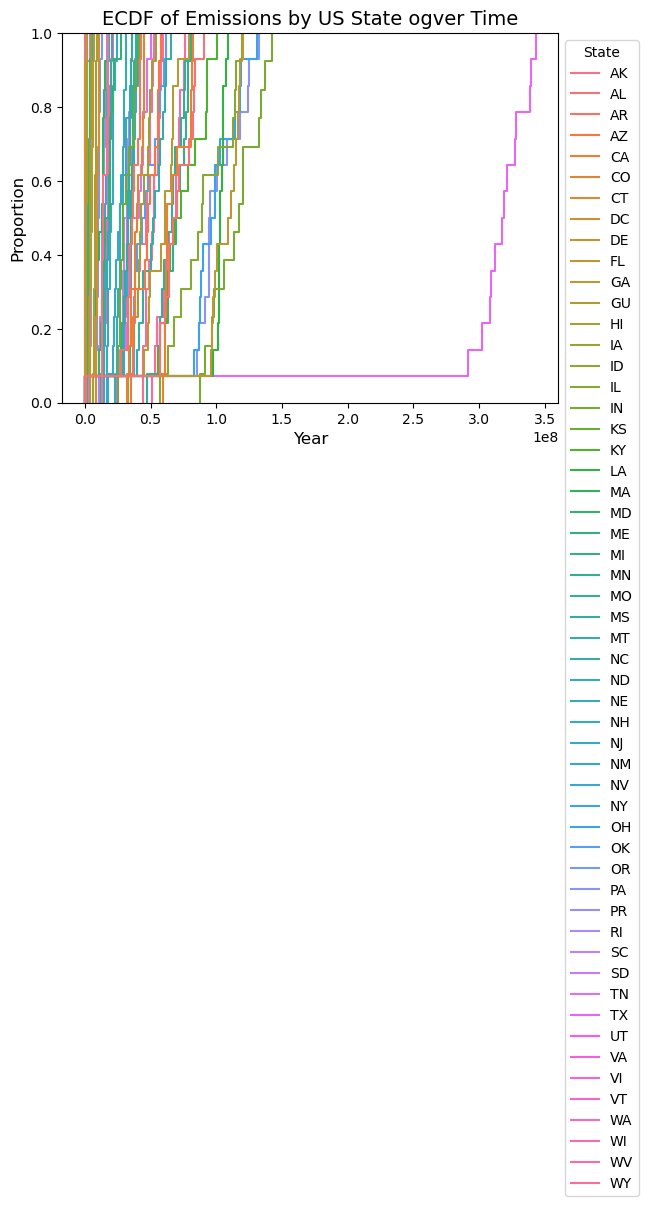

In [ ]:
#ecdf of CO2 emissions (no log transformation ) metric tons
ax = sns.ecdfplot(data=grouped_emissions, x="Unit CO2 emissions (non-biogenic) ", hue = "State")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("ECDF of Emissions by US State ogver Time", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)

Text(0.5, 1.0, 'KDE of Non-Biogenic C02 Emissions')

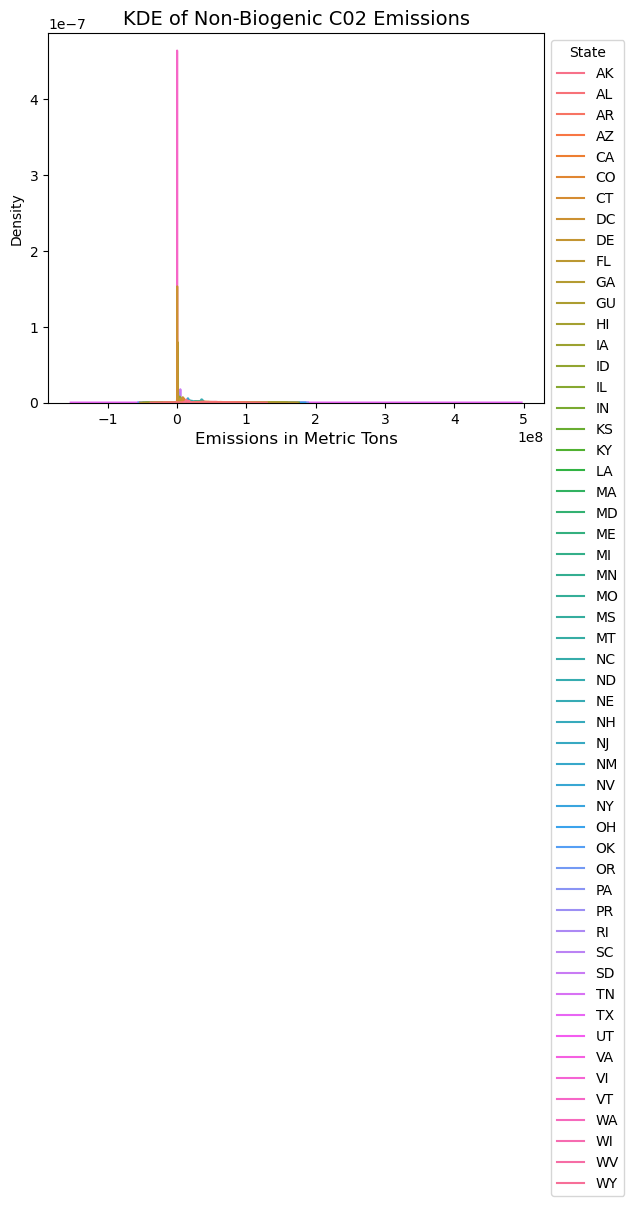

In [ ]:
#KDE of CO2 emissions (no log transformation ) metric tons
ax = sns.kdeplot(data=grouped_emissions, x="Unit CO2 emissions (non-biogenic) ", hue="State")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Emissions in Metric Tons", fontsize=12)
ax.set_title("KDE of Non-Biogenic C02 Emissions", fontsize=14)

## ECDF and KDE with Log

Text(0, 0.5, 'Proportion')

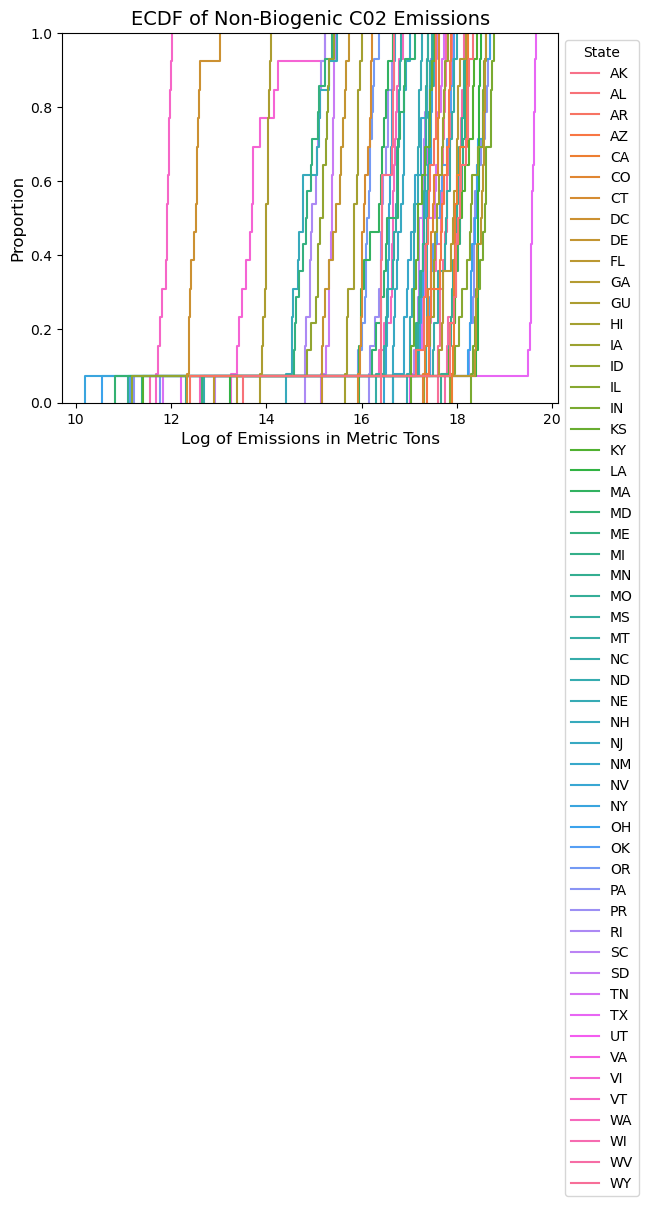

In [ ]:
#ecdf of logged CO2 emissions metric tons

ax = sns.ecdfplot(data=grouped_emissions, x="UnitE_Log", hue = "State")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("ECDF of Non-Biogenic C02 Emissions", fontsize=14)
ax.set_xlabel("Log of Emissions in Metric Tons", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)

Text(0.5, 1.0, 'KDE of Non-Biogenic C02 Emissions')

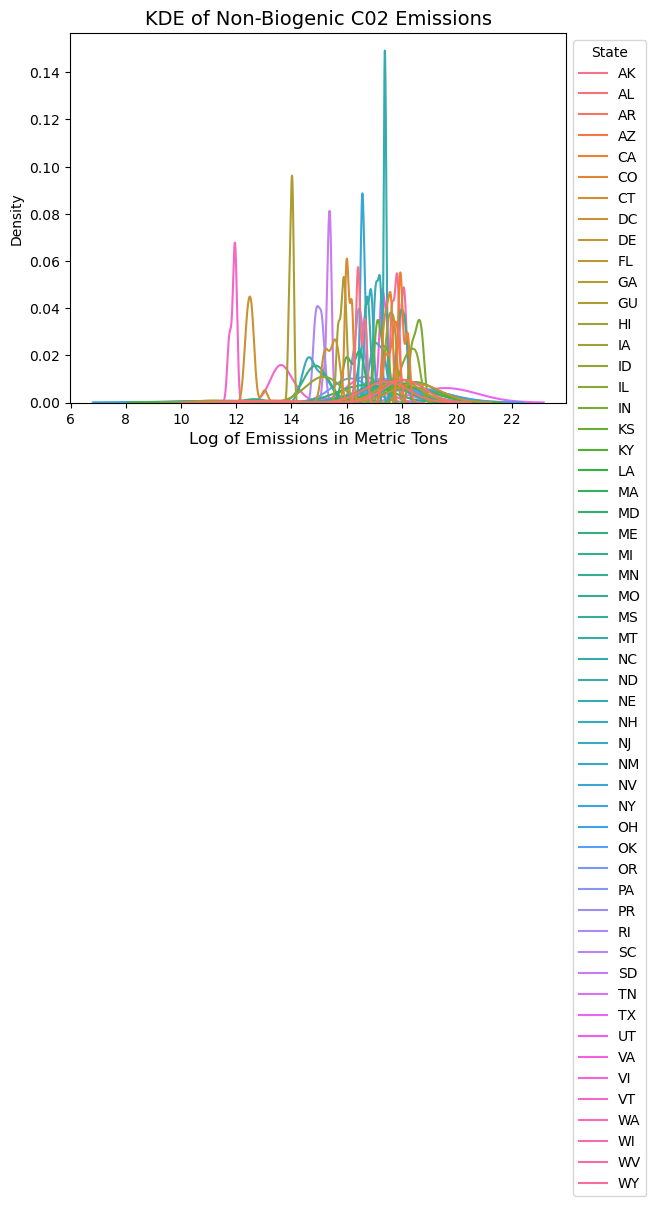

In [ ]:
#KDE of logged CO2 emissions metric tons

ax = sns.kdeplot(data=grouped_emissions, x="UnitE_Log", hue="State")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Log of Emissions in Metric Tons", fontsize=12)
ax.set_title("KDE of Non-Biogenic C02 Emissions", fontsize=14)

## Questions

How are you fitting your model to the phenomenon to get realistic properties of the data?
- We had to aggregate all the cities together to get one row per State and Year
- We picked Non-Biogenic CO2 emissions to focus on because it is the type of emission that is a result of non-renewable carbon sources such as Coal, Oil, Natural gas, and Petroleum products. These are human-caused CO2 emissions rather than natural processes. These carbon dioxide sources are directly addressable by humans and are therefore intriguing from a media and communications perspective. 
 
What challenges did you have to overcome? 
- The emissions were both large and constituted a large range - so taking a log helped standardize the data and make it easier to visualize. The overall quality of the data was good in part due to pre-cleaning the data ahead of visualizations. 

## Bootstrapping

In [12]:
def stat(x):
    stat = np.mean(x)
    return stat

In [13]:
def simulate_by_state(var, df, fcn, S=1000, plot=True):
    results = []

    for state in df['State'].dropna().unique():
        x = df.loc[df['State'] == state, var]

        estimates = []
        for s in range(S):
            x_s = x.sample(frac=1.0, replace=True)
            estimates.append(fcn(x_s))  

        estimates = np.array(estimates) 

       
        results.extend([{"State": state, "UnitE_Log": val} for val in estimates])

    df_boot = pd.DataFrame(results)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # --- KDE Plot (axes[0]) ---
        # The seaborn call creates the plot and the legend data
        sns.kdeplot(data=df_boot, x="UnitE_Log", hue="State", ax=axes[0])
        axes[0].set_title("KDE of Bootstrapped Estimates")

        # Access the legend object and set its location (e.g., inside top-right)
        legend0 = axes[0].get_legend()
        if legend0:
            legend0.set_bbox_to_anchor((1.0, 1.0))
            legend0.set_loc('upper right')
        
        # --- ECDF Plot (axes[1]) ---
        sns.ecdfplot(data=df_boot, x="UnitE_Log", hue="State", ax=axes[1])
        axes[1].set_title("ECDF of Bootstrapped Estimates")

        # Access the legend object and set its location (e.g., outside top-right)
        legend1 = axes[1].get_legend()
        if legend1:
            legend1.set_bbox_to_anchor((1.05, 1.0)) # Move slightly outside (1.05)
            legend1.set_loc('upper left')
            legend1.set_title('State')

        # Use plt.tight_layout() to prevent the outside legend from being cut off
        plt.tight_layout()

        plt.show()

    return df_boot

In [ ]:
var = 'UnitE_Log'
simulate_by_state(var, grouped_emissions, stat)

KeyboardInterrupt: 

## Bootstrapped ECDF/KDE for the overall log transformed bootstrapped (did not use this in #5 question)

In [ ]:
def simulate(var, df, fcn, S=1000, plot=True): # S variable is the amount of times you are bootstrapping
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S): # drawing 100 estimates from the mean 
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True) #frac --> 100% of sample (1.0)
            # this ^^ is basically saying to make a new sample with the same number of rows 
            # as the original sample size but replace the values when you draw one
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates


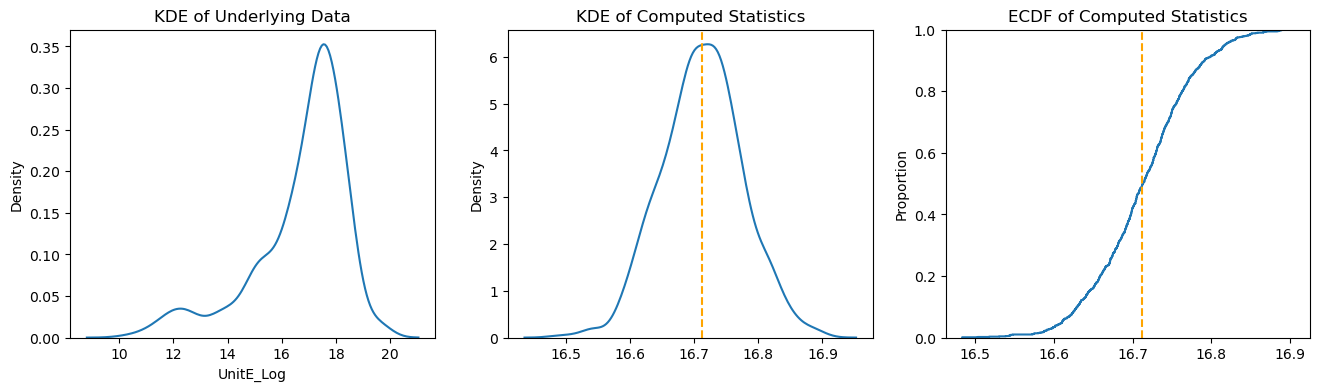

Variance of estimates is: 0.003979315482290395


array([16.63524842, 16.61640458, 16.70256325, 16.68018937, 16.67089367,
       16.80004498, 16.71306461, 16.63487417, 16.83204275, 16.62615173,
       16.8180261 , 16.71411638, 16.73941755, 16.68183775, 16.61863299,
       16.62645665, 16.69638016, 16.77959461, 16.81454578, 16.67729121,
       16.81549411, 16.74893086, 16.62414053, 16.67925709, 16.59172264,
       16.67998772, 16.73933333, 16.72987548, 16.70449466, 16.82516509,
       16.62086603, 16.72958542, 16.88632841, 16.7658897 , 16.72677531,
       16.70847498, 16.8131268 , 16.77605151, 16.75289062, 16.64876148,
       16.73753108, 16.7185615 , 16.63461184, 16.69878784, 16.64157772,
       16.81149722, 16.60149542, 16.68147699, 16.69406226, 16.71773995,
       16.78529342, 16.68204377, 16.67971432, 16.61311642, 16.75014649,
       16.75173552, 16.80409137, 16.64821586, 16.7141736 , 16.65892404,
       16.71186746, 16.65131436, 16.85075468, 16.66111915, 16.76796777,
       16.71757055, 16.72871003, 16.69764276, 16.78975451, 16.83

In [ ]:
var = 'UnitE_Log'
simulate(var, grouped_emissions, stat)